In [31]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [32]:
colab_path = 'ScadaData.txt'
local_path = 'C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt'

scada_data = pd.read_csv(local_path, delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])

turbine_names = scada_data['intObjectId'].unique()[0:4]
print(turbine_names)
print("Number of turbines: " + str(len(turbine_names)))

[1748 1749 1750 1751]
Number of turbines: 4


       WindSpeedMean    intObjectId
count  235816.000000  237195.000000
mean        5.231695    1761.148148
std         2.194863       8.040211
min         0.200000    1748.000000
25%         3.600000    1754.000000
50%         5.000000    1761.000000
75%         6.700000    1768.000000
max        19.400000    1776.000000


Text(0.5, 1.0, 'Raw Data')

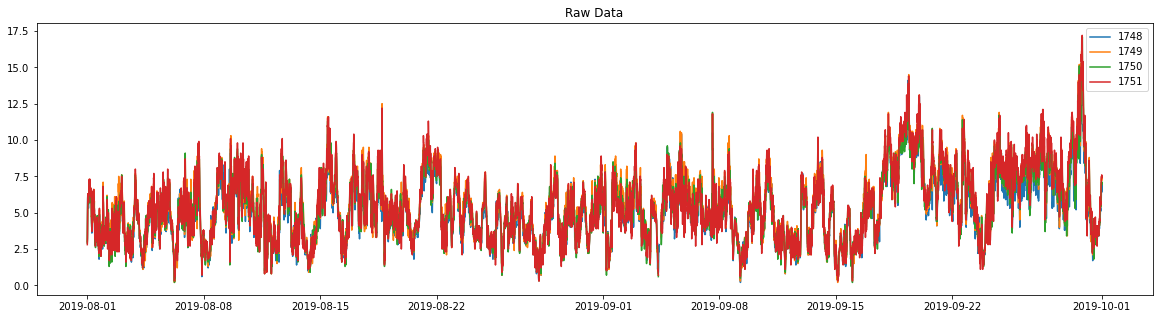

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline


wind_speed_data = scada_data[['dtTimeStamp','WindSpeedMean', 'intObjectId']]
wind_speed_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])
wind_speed_data.index=wind_speed_data['dtTimeStamp']
print(wind_speed_data.describe())

plt.figure(figsize=(20,5))
for turbine in turbine_names:
    plt.plot(wind_speed_data[wind_speed_data['intObjectId'] == turbine]["WindSpeedMean"], label=turbine)
plt.legend(loc='best')
plt.title('Raw Data')

In [34]:
from statsmodels.tsa.arima_model import ARIMA
import datetime as dt

def forecast_wind_speed(data, column_name):
    X = data[[column_name]]
    size = int(len(X) * 0.1)
    train, test = X[0:size], X[size:len(X)]
    history = train
    predictions = pd.DataFrame(index=test.index, columns=[column_name])
    for i, row in test.iterrows():
        model = ARIMA(history, order=(1,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0].flatten()[0]
        predictions.loc[i][column_name] = yhat
        history.loc[i] = row[column_name]


samples_to_use = 500
train_test_split = 0.04
n_steps = 1
filtered = wind_speed_data[wind_speed_data['intObjectId'].isin(turbine_names)]
averaged = filtered[['WindSpeedMean', 'intObjectId']].groupby('dtTimeStamp').mean()[['WindSpeedMean']]
predictions_df = pd.DataFrame(index=averaged[int(samples_to_use * train_test_split):samples_to_use].index)
average_mean_wind_speeds_real = averaged[0:samples_to_use]

for turbine in turbine_names:
    print('starting turbine: ' + str(turbine))
    data = wind_speed_data[wind_speed_data['intObjectId'] == turbine] 
    predictions = forecast_wind_speed(data, "WindSpeedMean")
    predictions_df[turbine] = predictions
    print('finished turbine: ' + str(turbine))
    
print(predictions_df)


starting turbine: 1748


LinAlgError: Array must not contain infs or NaNs

In [ ]:
predictions_df.head(5)

In [ ]:
average_mean_wind_speeds_predictions = predictions_df.mean(axis=1)
print(average_mean_wind_speeds_predictions)

In [ ]:
print(average_mean_wind_speeds_real)

In [ ]:
combined_df = pd.concat([average_mean_wind_speeds_predictions, average_mean_wind_speeds_real], axis=1)
print(combined_df)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(combined_df['WindSpeedMean'], color='blue', label='real')
plt.plot(combined_df[0], color='red', label='prediction')
plt.legend(loc='best')
plt.title('Real vs Predictions')

In [ ]:
combined_df = combined_df.dropna()

plt.hist([combined_df['WindSpeedMean'], combined_df[0]], bins=list(range(0,15)), label=['Real', 'Prediction'])
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(combined_df['WindSpeedMean'], combined_df[0])
print('Test MSE: %.3f' % error)